<a href="https://colab.research.google.com/github/MataKotos/machine-learning/blob/lab3/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ЗАДАНИЕ No 3

# БИНАРНАЯ КЛАССИФИКАЦИЯ СБАЛАНСИРОВАННОГО И
НЕСБАЛАНСИРОВАННОГО НАБОРА ДАННЫХ

Цели и задачи работы
Цель лабораторной работы: изучение принципов решения задачи классификации
с использованием методов машинного обучения.
Основные задачи:
* изучение инструментария Python для реализации алгоритмов бинарной
классификации;
* освоение метода логистической регрессии;
* изучение методов оценки корректности модели бинарной классификации;

Выполнение работы: Датасет – diabetes.csv Этот набор данных изначально был получен из Национального института диабета, заболеваний пищеварительной системы и почек. Целью является прогнозирование на основе диагностических измерений наличия у пациента диабета. На выборку этих случаев из более обширной базы данных накладывалось несколько ограничений. В частности, все пациенты здесь – женщины в возрасте не менее 21 года индейского происхождения Пима. Атрибуты:

* Pregnancies – количество беременностей
* Glucose – концентрация глюкозы в плазме крови в течение 2 часов при пероральном тесте на толерантность к глюкозе
* BloodPressure – диастолическое артериальное давление (мм рт.ст.)
* SkinThickness – толщина кожной складки на трицепсе (мм)
* Insulin – 2-часовой сывороточный инсулин (мкме/мл)
* BMI – индекс массы тела (вес в кг/(рост в м) ^2)
* DiabetesPedigreeFunction – функция родословной диабета
* Age: возраст (в годах)
* Outcome: переменная класса (0 или 1) – целевая переменная

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

file_path = '/content/gdrive/My Drive/diabetes.csv'

df = pd.read_csv(file_path)
print(df.head())

print("Форма датасета (shape):")
print(df.shape)

print("\nПервые 5 строк (head):")
print(df.head())

print("\nОписание числовых признаков (describe):")
print(df.describe())

print("\nОбщая информация (info):")
print(df.info())

Mounted at /content/gdrive
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Форма датасета (shape):
(768, 9)

Первые 5 строк (head):
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2  

Проверка сбалансированности целевой переменной

Распределение классов (Outcome):
Outcome
0    500
1    268
Name: count, dtype: int64


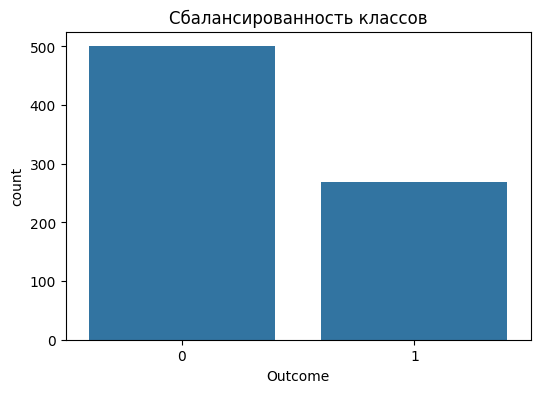

In [3]:
print("Распределение классов (Outcome):")
print(df['Outcome'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Сбалансированность классов')
plt.show()

In [4]:
#выводы через корреляцию с целевой переменной
corr_with_target = df.corr()['Outcome'].abs().sort_values(ascending=False)
print("Абсолютная корреляция признаков с Outcome:")
print(corr_with_target)

Абсолютная корреляция признаков с Outcome:
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


Проверка на нулевые значения там где их не должно быть

Количество нулей в признаках:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


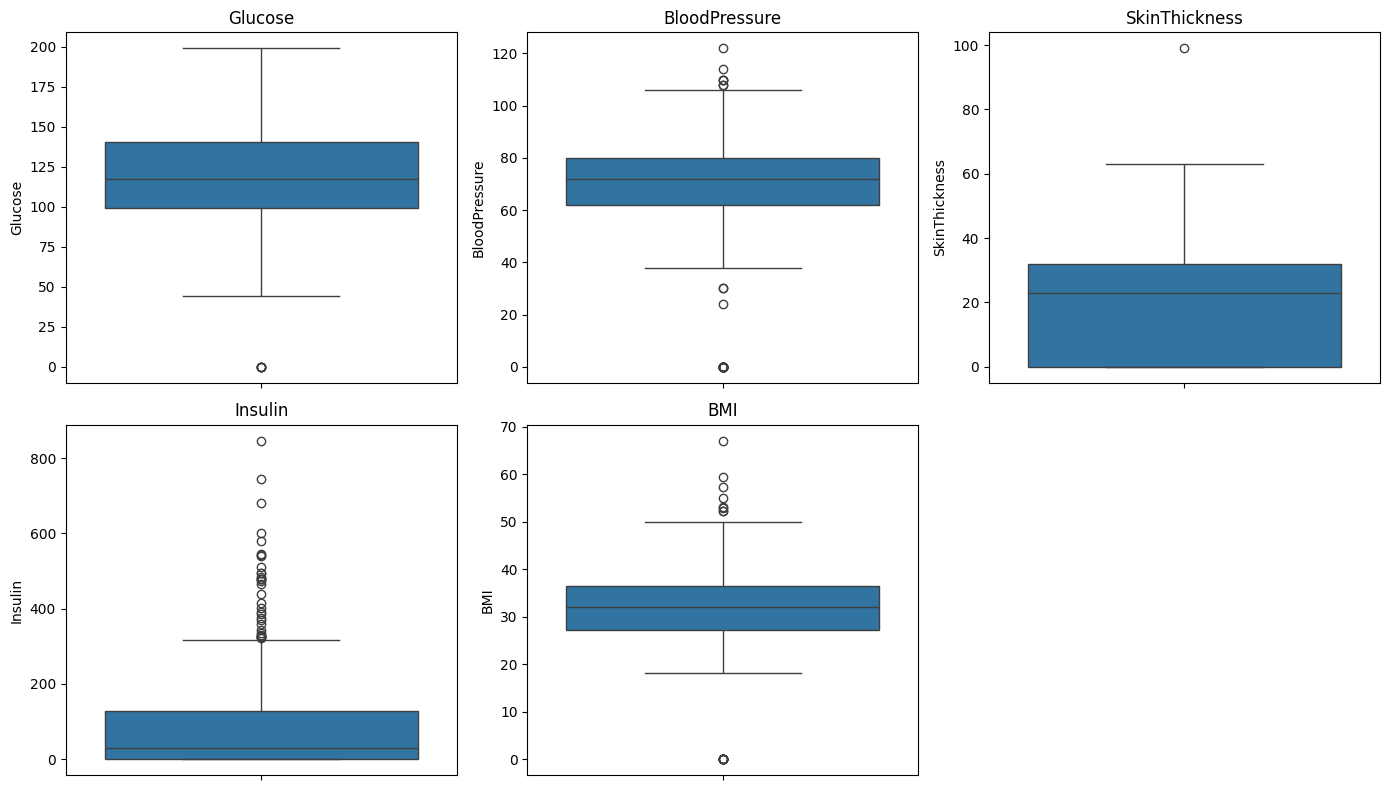

In [5]:
cols_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Количество нулей в признаках:")
print(df[cols_to_check].isin([0]).sum())

#визуализация распределений
plt.figure(figsize=(14, 8))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

Оччистка от нулей

In [6]:
#копия датафрейма чтобы не  повредить исходные данные
df_clean = df.copy()

# замена 0 на NaN
df_clean[cols_to_check] = df_clean[cols_to_check].replace(0, np.nan)

#заполнение средним по классу Outcome
for col in cols_to_check:
    df_clean[col] = df_clean.groupby('Outcome')[col].transform(lambda x: x.fillna(x.mean()))

#удаление оставшихся строк с NaN (если есть)
df_clean = df_clean.dropna()

Разделение датасета на признаки X и целевую переменную y и нормализация

In [9]:
#разделение
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

#нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Разбиение обработанного набора данных на обучающую и тестовую выборки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,          # 20% — тестовая выборка
    random_state=42,         # воспроизводимость
    stratify=y               # сохраняем пропорции классов
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)
print("\nРаспределение классов в обучающей выборке:")
print(pd.Series(y_train).value_counts())
print("\nРаспределение классов в тестовой выборке:")
print(pd.Series(y_test).value_counts())

Размер обучающей выборки: (614, 8)
Размер тестовой выборки: (154, 8)

Распределение классов в обучающей выборке:
Outcome
0    400
1    214
Name: count, dtype: int64

Распределение классов в тестовой выборке:
Outcome
0    100
1     54
Name: count, dtype: int64


Обучение модели логистической регрессии с автоматическим балансом весов

In [11]:
model = LogisticRegression(
    random_state=42,
    class_weight='balanced',   #учитывает несбалансированность
    max_iter=1000
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [12]:
y_pred = model.predict(X_test)

Отобразить корректность работы модели на тестовой и обучающей выборках
с помощью стандартных метрик библиотеки sklearn.

Точность (Accuracy): 0.76
Точность (Precision): 0.62
Полнота (Recall): 0.81
F1-мера: 0.70


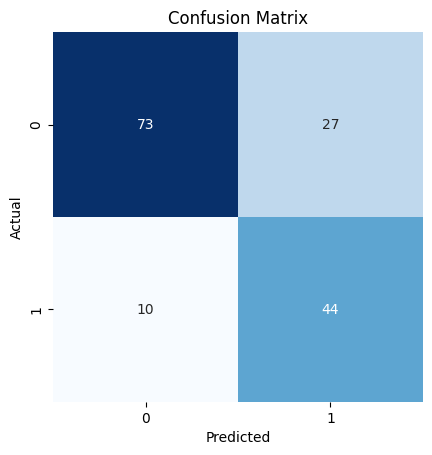

In [13]:
#рассчитываем и выводим метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Точность (Accuracy): {accuracy:.2f}")
print(f"Точность (Precision): {precision:.2f}")
print(f"Полнота (Recall): {recall:.2f}")
print(f"F1-мера: {f1:.2f}")

#построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

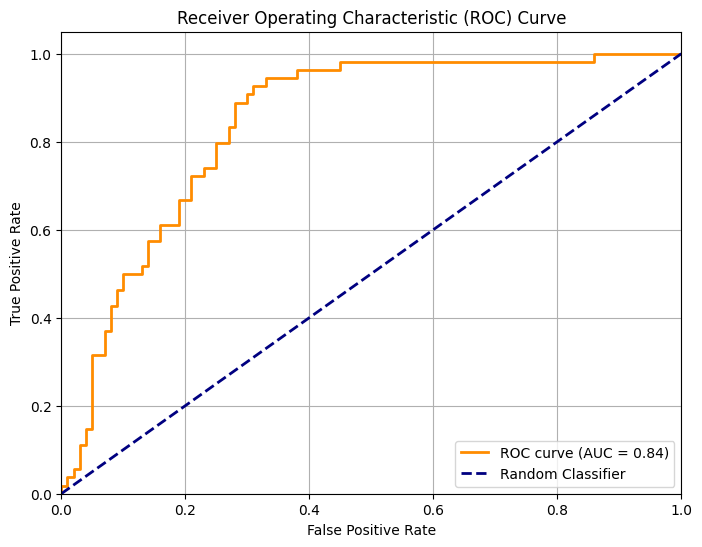

In [14]:
y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()